# Working with the `TonnageListAPI`

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/Tonnage%20List%20API/Working%20with%20the%20TonnageListAPI.ipynb).

## Setup
Install the Signal Ocean SDK:

In [ ]:
!pip install signal-ocean

Set your subscription key, acquired here: [https://apis.signalocean.com/profile](https://apis.signalocean.com/profile)

In [6]:
signal_ocean_api_key = ""  # replace with your subscription key

## Retrieving a historical tonnage list
First, we need to create an instance of the `TonnageListAPI`:

In [7]:
from signal_ocean import Connection
from signal_ocean.tonnage_list import TonnageListAPI

connection = Connection(signal_ocean_api_key)
api = TonnageListAPI(connection)


Then, we need to determine the parameters of the **historical tonnage list** (**HTL**). In order to fetch an HTL, we will need to specify:
- a loading port,
- a vessel class,
- a time frame.

Ports and vessel classes can be retrieved through the `get_ports` and `get_vessel_classes` methods:

In [8]:
api.get_vessel_classes()


(VesselClass(id=60, name='VLGCLpg'),
 VesselClass(id=61, name='MidsizeLpg'),
 VesselClass(id=62, name='HandyLpg'),
 VesselClass(id=63, name='SmallLpg'),
 VesselClass(id=69, name='VLOC'),
 VesselClass(id=70, name='Capesize'),
 VesselClass(id=72, name='PostPanamaxDry'),
 VesselClass(id=74, name='PanamaxDry'),
 VesselClass(id=75, name='Supramax'),
 VesselClass(id=76, name='Handymax'),
 VesselClass(id=77, name='Handysize'),
 VesselClass(id=78, name='ULCV'),
 VesselClass(id=79, name='NewPanamaxContainer'),
 VesselClass(id=80, name='PostPanamaxContainer'),
 VesselClass(id=81, name='PanamaxContainer'),
 VesselClass(id=82, name='FeedermaxContainer'),
 VesselClass(id=83, name='FeederContainer'),
 VesselClass(id=84, name='VLCC'),
 VesselClass(id=85, name='Suezmax'),
 VesselClass(id=86, name='Aframax'),
 VesselClass(id=87, name='PanamaxTanker'),
 VesselClass(id=88, name='MR2'),
 VesselClass(id=89, name='MR1'),
 VesselClass(id=90, name='Small'),
 VesselClass(id=91, name='LNGLng'),
 VesselClass(id=

Ports can be looked up by their name using the `PortFilter`:

In [9]:
from signal_ocean.tonnage_list import PortFilter

api.get_ports(PortFilter(name_like="rot"))

(Port(id=3689, name='Rotterdam'),
 Port(id=6625, name='Rota'),
 Port(id=8920, name='Crotone'),
 Port(id=15617, name='Rarotonga'))

And so can vessel classes with the use of the `VesselClassFilter`:

In [10]:
from signal_ocean.tonnage_list import VesselClassFilter

api.get_vessel_classes(VesselClassFilter(name_like="MAX"))

(VesselClass(id=72, name='PostPanamaxDry'),
 VesselClass(id=74, name='PanamaxDry'),
 VesselClass(id=75, name='Supramax'),
 VesselClass(id=76, name='Handymax'),
 VesselClass(id=79, name='NewPanamaxContainer'),
 VesselClass(id=80, name='PostPanamaxContainer'),
 VesselClass(id=81, name='PanamaxContainer'),
 VesselClass(id=82, name='FeedermaxContainer'),
 VesselClass(id=85, name='Suezmax'),
 VesselClass(id=86, name='Aframax'),
 VesselClass(id=87, name='PanamaxTanker'))

Note that the search is case-insensitive and does not require specifying exact names.

We want our HTL to contain Aframax vessels in Ceyhan, with a 6-day forward laycan end, for the last 90 days:

In [11]:
from datetime import timedelta, date

vessel_class_filter = VesselClassFilter(name_like="aframax")
vessel_class = api.get_vessel_classes(vessel_class_filter)[0]

port_filter = PortFilter(name_like="ceyhan")
port = api.get_ports(port_filter)[0]

laycan_end_in_days = 6
today = date.today()
start_date = today - timedelta(days=5)

With the parameters above, we can now request an HTL:

In [12]:
from signal_ocean.tonnage_list import DateRange

htl = api.get_historical_tonnage_list(
    port, vessel_class, laycan_end_in_days, DateRange(start_date, today)
)


The resulting historical tonnage list is a Python object that contains a collection of tonnage lists, each of which has a timestamp and a collection of vessel data. The tonnage lists are ordered by date in descending order:

In [13]:
yesterdays_tl = htl[1]
print("Date:", yesterdays_tl.date)
print("Vessel count:", len(yesterdays_tl.vessels))
print("Example vessel:", yesterdays_tl.vessels[0])

Date: 2021-11-17 12:00:00+00:00
Vessel count: 76
Example vessel: Vessel(imo=8508292, name='Gunung Kemala', vessel_class='Aframax', ice_class=None, year_built=1986, deadweight=86962, length_overall=242.0, breadth_extreme=42, market_deployment='Program', push_type='Not Pushed', open_port='Balongan Terminal', open_date=datetime.datetime(2021, 2, 16, 2, 16, 32, 879000, tzinfo=datetime.timezone.utc), operational_status='Loading', commercial_operator='Pertamina', commercial_status='Available', eta=datetime.datetime(2021, 3, 9, 7, 0, tzinfo=datetime.timezone.utc), latest_ais=datetime.datetime(2021, 2, 9, 16, 4, 53, tzinfo=datetime.timezone.utc), subclass='Dirty', willing_to_switch_subclass=False, open_prediction_accuracy='Narrow Area', open_areas=(Area(name='Indonesia', location_taxonomy='Narrow Area'), Area(name='South East Asia', location_taxonomy='Wide Area'), Area(name='Indonesia', location_taxonomy='Country')), availability_port_type='Prediction', availability_date_type='Prediction')


The result can also be converted into a Pandas data frame:

In [14]:
data_frame = htl.to_data_frame()
data_frame

name vessel_class ice_class  \
date                      imo                                               
2021-11-18 12:00:00+00:00 8508292    Gunung Kemala      Aframax       NaN   
                          9038854     Warrior King      Aframax       NaN   
                          9252967             Wind      Aframax       NaN   
                          9258894  Golden Splendor      Aframax       NaN   
                          9110183      Morning Sun      Aframax       NaN   
...                                            ...          ...       ...   
2021-11-13 12:00:00+00:00 9703332     Front Jaguar      Aframax        1C   
                          9276597     Minerva Lisa      Aframax        1C   
                          9038880            Nereo      Aframax       NaN   
                          9417309        Valfoglia      Aframax       NaN   
                          9370848    Anafi Warrior      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-11-18 12:00:00+00:00 8508292        1986       86962          242.00   
                          9038854        1993       99371          243.97   
                          9252967        2003      105387          237.74   
                          9258894        2004      114809          251.60   
                          9110183        1996       98743          244.80   
...                                       ...         ...             ...   
2021-11-13 12:00:00+00:00 9703332        2016      109900          252.00   
                          9276597        2004      103755          243.57   
                          9038880        1993       99355          244.00   
                          9417309        2009      109060          243.00   
                          9370848        2009      107593          243.80   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-11-18 12:00:00+00:00 8508292               42    Dirty   
                          9038854               46    Dirty   
                          9252967               42    Dirty   
                          9258894               44    Dirty   
                          9110183               41    Dirty   
...                                            ...      ...   
2021-11-13 12:00:00+00:00 9703332               44    Dirty   
                          9276597               42    Dirty   
                          9038880               46    Dirty   
                          9417309               42    Dirty   
                          9370848               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-11-18 12:00:00+00:00 8508292                         Program   
                          9038854                         Program   
                          9252967                         Program   
                          9258894                        Contract   
                          9110183                        Contract   
...                                                           ...   
2021-11-13 12:00:00+00:00 9703332                            Spot   
                          9276597                            Spot   
                          9038880                         Program   
                          9417309                         Program   
                          9370848                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-11-18 12:00:00+00:00 8508292              Not Pushed  ...   
                          9038854              Not Pushed  ...   
                          9252967              Not Pushed  .

### Example 1 - Plotting a supply trend
The data frame format makes it very easy to generate a supply trend plot.

We'll generate a supply trend from the beginning of the year, but we'll also filter the vessel list by looking for vessels that:
- are pushed,
- have a market deployment type of "Relet" or "Spot",
- their commercial status is available, cancelled or failed,
- are crude oil tankers (their vessel subclass is "Dirty"),
- their AIS information is no older than 5 days.

Filtering can be achieved by creating an instance of a `VesselFilter` and passing it to the `get_historical_tonnage_list` method. A `VesselFilter` meeting the above criteria will look as follows:

In [15]:
from signal_ocean.tonnage_list import (
    VesselFilter,
    PushType,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
)

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[
        CommercialStatus.AVAILABLE,
        CommercialStatus.CANCELLED,
        CommercialStatus.FAILED,
    ],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5,
)


Note the usage of the `PushType`, `MarketDeployment`, `CommercialStatus`, and `VesselSubclass`. These are enum-like classes that contain constants for all the possible values for a given `VesselFilter` parameter. To list the available values for any of the classes, just invoke `list()` on the class:

In [16]:
list(CommercialStatus)

['On Subs', 'Failed', 'Cancelled', 'Available', 'Poss Fixed']

You can use these values directly or use a corresponding class member:

In [17]:
CommercialStatus.ON_SUBS == 'On Subs'

True

Let's get the HTL for our filter:

In [18]:
beginning_of_year = date(today.year, 1, 1)

htl_for_supply_trend = api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, today),
    vessel_filter=vessel_filter,
)

supply_trend_data_frame = htl_for_supply_trend.to_data_frame()
supply_trend_data_frame


name vessel_class  \
date                      imo                                          
2021-11-18 12:00:00+00:00 9457608               Leo Sun      Aframax   
                          9402263               Seliger      Aframax   
                          9395331              Corossol      Aframax   
                          9296195                 Paros      Aframax   
                          9370836           New Amorgos      Aframax   
...                                                 ...          ...   
2021-11-13 12:00:00+00:00 9783916    Southern Reverence      Aframax   
                          9439670  Captain A. Stellatos      Aframax   
                          9703332          Front Jaguar      Aframax   
                          9276597          Minerva Lisa      Aframax   
                          9370848         Anafi Warrior      Aframax   

                                  ice_class  year_built  deadweight  \
date                      imo                                         
2021-11-18 12:00:00+00:00 9457608       NaN        2011      114531   
                          9402263       NaN        2009      115126   
                          9395331       NaN        2010      106898   
                          9296195       NaN        2003      107197   
                          9370836       NaN        2008      107510   
...                                     ...         ...         ...   
2021-11-13 12:00:00+00:00 9783916       NaN        2018      108534   
                          9439670       NaN        2010      105849   
                          9703332        1C        2016      109900   
                          9276597        1C        2004      103755   
                          9370848       NaN        2009      107593   

                                   length_overall  breadth_extreme subclass  \
date                      imo                                                 
2021-11-18 12:00:00+00:00 9457608          243.80               42    Dirty   
                          9402263          243.80               42    Dirty   
                          9395331          243.80               42    Dirty   
                          9296195          247.00               42    Dirty   
                          9370836          243.80               42    Dirty   
...                                           ...              ...      ...   
2021-11-13 12:00:00+00:00 9783916          243.80               42    Dirty   
                          9439670          243.97               42    Dirty   
                          9703332          252.00               44    Dirty   
                          9276597          243.57               42    Dirty   
                          9370848          243.80               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-11-18 12:00:00+00:00 9457608                            Spot   
                          9402263                            Spot   
                          9395331                            Spot   
                          9296195                            Spot   
                          9370836                            Spot   
...                                                           ...   
2021-11-13 12:00:00+00:00 9783916                            Spot   
                          9439670                            Spot   
                          9703332                            Spot   
                          9276597                            Spot   
                          9370848                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-11-18 12:00:00+00:00 9457608                  Pushed  ...   
                          9402263                  Pushed  ...   


Now, we can generate the plot:

<AxesSubplot:title={'center':'Ceyhan Aframax Laycan 6 days'}, xlabel='date', ylabel='Vessel count'>

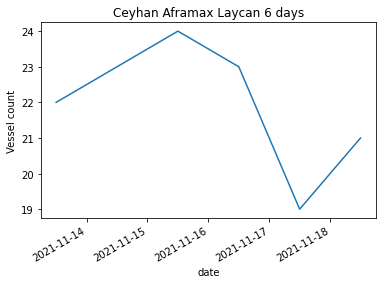

In [22]:
from signal_ocean.tonnage_list import IndexLevel

supply_trend = supply_trend_data_frame.groupby(
    IndexLevel.DATE, sort=True
).size()

plot = supply_trend.plot()
plot.set_ylabel("Vessel count")
plot.set_title("Ceyhan Aframax Laycan 6 days")
plot


### Example 2 - Generating an Excel sheet
The data frame can be easily saved as an Excel file by using Pandas's built-in `to_excel()` function.

Before we do that, we need to remove all the time zone information from all timestamps in the data frame. This is because Excel does not support storing time zone information along with timestamps. However, Signal Ocean's SDK always provides time zone information to make all timestamp-based computation unambiguous.

In [20]:
from signal_ocean.tonnage_list import Column

without_time_zones = (
    supply_trend_data_frame.reset_index()
    .astype(
        {
            IndexLevel.DATE: "datetime64[ns]",
            Column.OPEN_DATE: "datetime64[ns]",
            Column.ETA: "datetime64[ns]",
            Column.LATEST_AIS: "datetime64[ns]",
        }
    )
    .set_index([IndexLevel.DATE, IndexLevel.IMO])
)


C:\Users\PC863~1.ROM\AppData\Local\Temp/ipykernel_16416/191344502.py:4: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  supply_trend_data_frame.reset_index()


Now, we can generate the Excel file:

In [21]:
without_time_zones.to_excel('Ceyhan_Afra_6days_history.xlsx')